# pymc-continuous-kronecker
GP model using pymc on continuous data (week, longitude and latitude of county centroid)

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
from plotnine import *

## Data preprocess
Import chickenpox data and pivot into tabular format with x, y, time, counts

In [26]:
df = pd.read_csv("data/hungary_chickenpox.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df = df.set_index("Date")
df = df.groupby([(df.index.year)]).sum()
df.head()

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
Date,,,,,,,,,,,,,,,,,,,,
2005,4562,2051,2766,3544,4027,1431,2468,3524,4122,1841,3486,2591,852,4707,1694,1986,955,2099,2916,1591
2006,6498,1863,1969,1191,2173,2703,1603,1977,1762,1310,2516,1434,1415,4848,2174,1636,1919,1623,3679,1648
2007,6311,2345,2197,2780,3715,1614,1949,2672,2863,2973,1751,1500,2039,5943,1507,2036,1114,760,2270,1236
2008,4441,1815,1711,1451,3015,1222,2353,2453,2287,1219,1981,1479,1135,3521,1252,1963,835,610,1784,530
2009,5527,1591,1607,1409,3086,2584,1053,1996,3386,1614,2197,1394,1255,4304,1476,1441,1332,2059,1232,909


In [27]:
df["year"] = df.index
# df.drop("Date", axis=1, inplace=True)
df = pd.melt(df, id_vars="year", var_name="na_caps", value_name="cases")



In [29]:
centroids = pd.read_csv("data/hungary_county_centroids.csv")
df = df.merge(centroids[["na_caps", "long", "lat"]], on="na_caps", how="left")
df = df[["year", "na_caps", "long", "lat", "cases"]]
df.head()

,year,na_caps,long,lat,cases
0,2005,BUDAPEST,19.110875,47.488038,4562
1,2006,BUDAPEST,19.110875,47.488038,6498
2,2007,BUDAPEST,19.110875,47.488038,6311
3,2008,BUDAPEST,19.110875,47.488038,4441
4,2009,BUDAPEST,19.110875,47.488038,5527


/Users/tar15/opt/anaconda3/envs/spatiotemporal/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


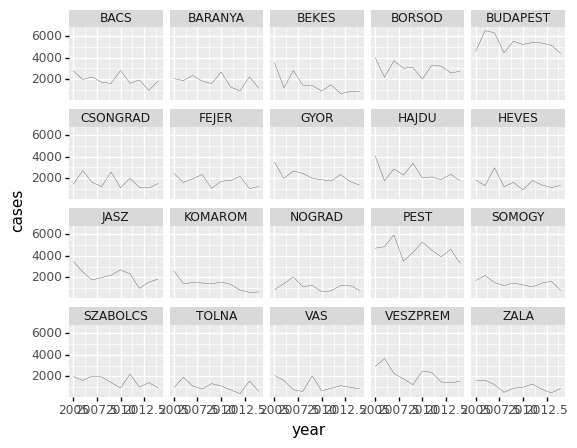

<ggplot: (342449098)>

In [31]:
(ggplot(df, aes(x="year", y="cases"))
+ geom_line(size=0.1)
+ facet_wrap("~na_caps"))

In [33]:
X = df[["long", "lat"]].to_numpy()
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

t = df[["year"]].to_numpy()
t = (t - np.mean(t, axis=0)) / np.std(t, axis=0)

cases = df[["cases"]].to_numpy()

In [35]:
np.unique(X).shape

(40,)

## pymc model

In [36]:
with pm.Model() as model:
    mean = pm.Normal("alpha", sigma=10.0)

    sigma = pm.HalfNormal("sigma", sigma=5.0)
    rho = pm.HalfNormal("rho", sigma=5.0)
    kernel = sigma**2 * pm.gp.cov.Matern52(2, ls=rho)
    
    gp_space = pm.gp.Latent(cov_func=kernel)

    gp_space = gp_space.prior("gp_space", X=X)
    # gp_time = gp_time.prior("gp_time", X=t)
    latent_rate = pm.math.exp(mean + gp_space)

    pm.Poisson("cases", mu=latent_rate, observed=cases)

In [37]:
with model:
    idata = pm.sample(1000, tune=1000)

KeyboardInterrupt: 